## Annotated timeline plot

In this part, we will try out the timeline plot using the different libraries. The example we will go through is plotting the 'trendiness' of liverpool according to google trends. You can download a similar file by going through this [link](https://trends.google.com/trends/explore?date=2019-01-01%202019-12-30&q=liverpool).

We will highlight top [timepoints](https://www.worldfootball.net/teams/liverpool-fc/2019/3/) at the peak trend of liverpool on google.



In [318]:
import pandas as pd
from mizani.formatters import date_format

In [319]:
timeline_data = pd.read_csv('liverpool_timeline.csv', skiprows=1, parse_dates=['Week'])

In [320]:
keydates = [('2019/05/01', 'Champions League Semi Final (A)', 'Lose'),
            ('2019/05/07', 'Champions League Semi Final (H)', 'Win'),
            ('2019/06/01', 'Champions League Final', 'Win'),
            ('2019/12/21', 'Club World Cup Final', 'Win')]

keydates = list(map(lambda pair: (pd.to_datetime(pair[0]), *pair[1:]), keydates))

In [321]:
timeline_data = timeline_data.rename(columns={'Week': 'week_start', 'liverpool: (Worldwide)':'trend_score'})
timeline_data['week_end'] = timeline_data['week_start'] + pd.Timedelta(days=6)


In [322]:
def tag_weeks_with_keydates(data):
    
    data['tag'] = None
    data['shape'] = None
    for (keydate, tagged_text, status) in keydates:
        is_within_week = (keydate>= data.week_start) & (keydate <= data.week_end)
        timeline_data.loc[is_within_week, 'tag'] = tagged_text
        timeline_data.loc[is_within_week, 'status'] = status
    timeline_data['status'] = pd.Categorical(timeline_data['status'], ordered=True,
                   categories=['Win', 'Lose'])
      
        

In [323]:
tag_weeks_with_keydates(timeline_data)

### Way 1 : Plotnine


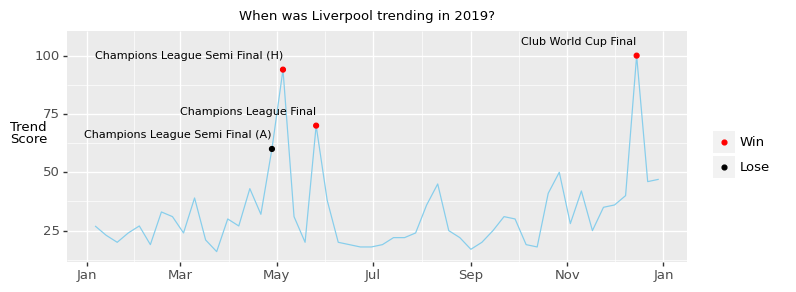

<ggplot: (-9223363256948008174)>

In [553]:
from plotnine import  *
import plotnine
plotnine.options.figure_size = (8,3)
g = (ggplot(timeline_data, aes(x='week_start', y='trend_score', label='tag')) + 
    geom_line( color='skyblue') + 
    geom_point(timeline_data[~timeline_data.tag.isnull()],aes(color="status")
              ) +
    scale_color_manual(values=("red", "black")) + 
    labs(title='When was Liverpool trending in 2019?',
         x='',
         y='Trend\nScore',
         color= '') +
    scale_x_datetime(labels = date_format("%b")) + 
    geom_text(size=8, nudge_y=6, hjust="right",na_rm=True) + 
    #theme_classic() +
     theme(text=element_text(size=9.5),
           axis_title_y=element_text(angle = 0)
          )
    )
g

### Way 2: Matplotlib

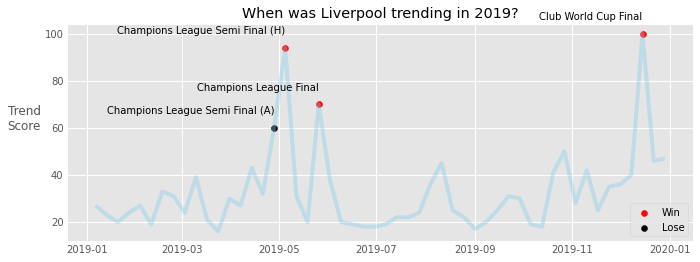

In [544]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot('111')


ax.plot(timeline_data.week_start, timeline_data.trend_score, color='skyblue',
                alpha=0.4)



for status, color in zip(['Win', 'Lose'], ['red', 'black']):
    event_timeline = timeline_data[timeline_data.status == status]  
    ax.scatter(event_timeline.week_start, event_timeline.trend_score,
              c=color, label= status)
    
event_timeline = timeline_data[~timeline_data.tag.isnull()]

for index, row in event_timeline.iterrows():
    ax.text(row.week_start, row.trend_score+6, row.tag, ha='right')


ax.set_title('When was Liverpool trending in 2019?')
ax.set_ylabel('Trend\nScore', rotation=0, ha='right')
ax.legend(title='', loc=4)





### Way 3: Seaborn

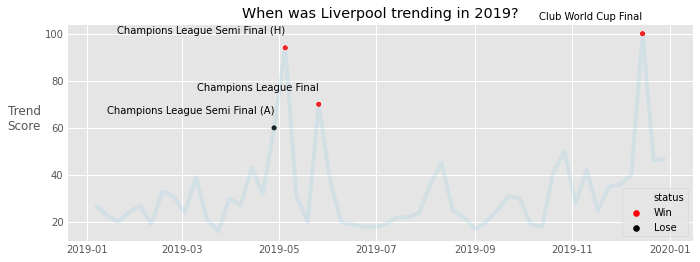

In [551]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 4]

ax = sns.lineplot(x='week_start', y='trend_score', color='skyblue', data=timeline_data, alpha=0.2)

event_timeline = timeline_data[~timeline_data.tag.isnull()]

sns.scatterplot(x='week_start', y='trend_score', hue='status', data= event_timeline, ax=ax,
               palette=['red', 'black'], hue_order=['Win', 'Lose'])


event_timeline = timeline_data[~timeline_data.tag.isnull()]

for index, row in event_timeline.iterrows():
    ax.text(row.week_start, row.trend_score+6, row.tag, ha='right')

ax.set_title('When was Liverpool trending in 2019?')
ax.set_ylabel('Trend\nScore', rotation=0, ha='right')
ax.set_xlabel('')
ax.legend(title=None, loc=4)


### Way 4: Altair

In [547]:
import altair as alt


base = alt.Chart(timeline_data).mark_line( color="lightblue").encode(
    alt.X('week_start:T',  axis=alt.Axis(title='', format='%b')),
    alt.Y('trend_score:Q', axis=alt.Axis(title='Trend Score', titleAngle=0, titleAlign='right'))
).properties(
    width=550,
    height=200,
    title= {'text' : 'When was Liverpool trending in 2019?'}
)

circles = base.mark_circle().encode(
    alt.Color('status:O', scale=alt.Scale(domain=['Win', 'Lose'], range=['red', 'black']),
             title="")
    
).transform_filter((alt.datum.status=='Win') | (alt.datum.status=='Lose'))


text = base.mark_text(
    align='right',
    baseline='middle',
    color='black',
    dy=-10
   
).encode(
    text='tag:O'
).transform_filter((alt.datum.status=='Win') | (alt.datum.status=='Lose'))




base + circles + text

alt.LayerChart(...)

### Way 5 : Plotly

In [548]:
### https://community.plotly.com/t/editing-the-legend-symbols/2113
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
                x=timeline_data.week_start, 
                y=timeline_data.trend_score,
                text=event_timeline.tag,
                showlegend=False,
                #fill='tozeroy'
                )

             ) 

for status, color in zip(['Win', 'Lose'], ['red', 'black']):
    event_timeline = timeline_data[timeline_data.status==status]

    fig.add_trace(go.Scatter(
                    x=event_timeline.week_start, 
                    y=event_timeline.trend_score, 
                    mode='markers',
                    marker=dict(color=color),
                    name=status,

                    )

                 ) 
    fig.add_trace(go.Scatter(
                    x=event_timeline.week_start, 
                    y=event_timeline.trend_score, 
                    text=event_timeline.tag,
                    mode='text',
                    showlegend=False,
                    textposition="top left",
                    cliponaxis=False
                    )

                 ) 
    
    


fig.update_layout(
    title="When was Liverpool trending in 2019?",
    xaxis_title="",
    yaxis_title="Trend Score",
    legend_title="",
     width=850, height=400
)



fig.show()

